In [1]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setup sqlite
sqlite_file = 'hyper_live.db'
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [3]:
# read ALL tweets from db
all_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw", connection)
all_tweets['createdAt'] = pd.to_datetime(all_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
all_tweets.index = all_tweets['createdAt']
print("{} tweets in db".format(len(all_tweets)))

5438 tweets in db


In [13]:
# Construct a dataframe joining data from TweetsRaw and BandTweets
band_tweets = pd.read_sql_query("SELECT bt.bandId, \
                                        b.name AS bandName, \
                                        b.codedName AS bandCodedName, \
                                        b.headLevel AS headLevel, \
                                        b.popularity AS popularity, \
                                        tr.* \
                                 FROM BandTweets AS bt\
                                 LEFT JOIN TweetsRaw AS tr ON bt.tweetRawId == tr.id \
                                 LEFT JOIN Bands AS b ON bt.bandId == b.id", connection)
band_tweets['createdAt'] = pd.to_datetime(band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
band_tweets.index = band_tweets['createdAt']
print("{} band tweets in db".format(band_tweets.shape[0]))

2206 band tweets in db


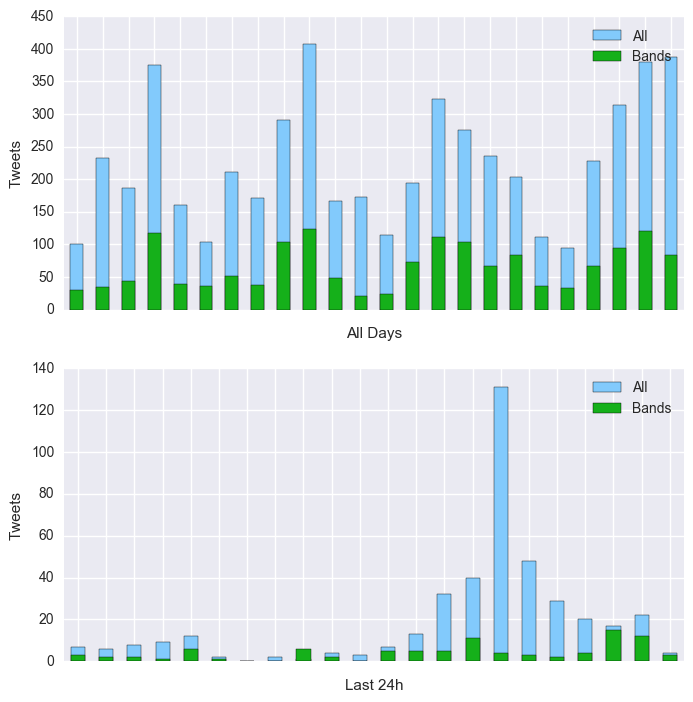

In [5]:
# https://chrisalbon.com/python/pandas_group_data_by_time.html

# timeline plot comparing alltweets vs bandtweets
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(top=1.2)
ax1 = fig.add_subplot(211)
all_tweets.resample('D').count()['tweetId'].plot(kind='bar', \
                                                 color=sns.xkcd_rgb['sky'], \
                                                 label='All', \
                                                 ax=ax1)
band_tweets.resample('D').count()['bandId'].plot(kind='bar', \
                                                 color=sns.xkcd_rgb['green'], \
                                                 label='Bands', \
                                                 ax=ax1)
ax1.set_xlabel("All Days")
ax1.set_xticklabels([])
#ax1.set_xticklabels(list(np.arange(min(all_tweets['createdAt']).day, max(all_tweets['createdAt']).day + 1)), rotation=None)
ax1.set_ylabel("Tweets")
ax1.legend()


# get recent tweets (last 24h)
recent_all_tweets = all_tweets[ all_tweets['createdAt'] > (datetime.now() - timedelta(hours=24))]
recent_band_tweets = band_tweets[ band_tweets['createdAt'] > (datetime.now() - timedelta(hours=24))]

# plot last day of tweets & band_tweets
ax2 = fig.add_subplot(212)
ax2 = recent_all_tweets.resample('H').count()['tweetId'].plot(kind='bar', \
                                                              color=sns.xkcd_rgb['sky'], \
                                                              label='All', \
                                                              ax=ax2)
recent_band_tweets.resample('H').count()['bandId'].plot(kind='bar', \
                                                        color=sns.xkcd_rgb['green'], \
                                                        label='Bands', \
                                                        ax=ax2)
ax2.set_xlabel("Last 24h")
ax2.set_xticklabels([])
ax2.set_ylabel("Tweets")
ax2.legend()

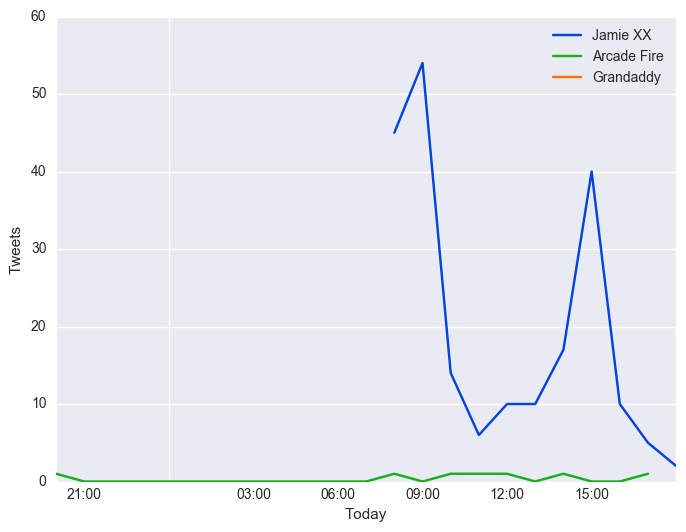

In [39]:
# Timeline of n bands between start and end times

# set band to filter
bands = [{'codedName':'jamiexx', 'name':'Jamie XX', 'color':'blue'},
         {'codedName':'arcadefire', 'name':'Arcade Fire', 'color':'green'},
         {'codedName':'grandaddy', 'name':'Grandaddy', 'color':'orange'}];

# set start-end times in UTC
start = '2017-05-28 20:00'
end   = '2017-05-29 20:00'
start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M')
end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M')

# create figrue
fig = plt.figure(figsize=(8, 6))
ax3 = fig.add_subplot(111)

for band in bands:

    # filter by band
    single_band_tweets = band_tweets[band_tweets['bandCodedName'] == band['codedName']]

    # create a datetime version of the createdAt column and filter by start and end
    single_band_tweets = single_band_tweets[single_band_tweets['createdAt'] > start_datetime]
    single_band_tweets = single_band_tweets[single_band_tweets['createdAt'] < end_datetime]

    # plot tweets
    ax3 = single_band_tweets.resample('H').count()['tweetId'].plot(kind='line', \
                                                                  color=sns.xkcd_rgb[band['color']], \
                                                                  label=band['name'], \
                                                                  ax=ax3)

ax3.set_xlabel("Today")
ax3.set_xticklabels([])
ax3.set_ylabel("Tweets")
ax3.legend()

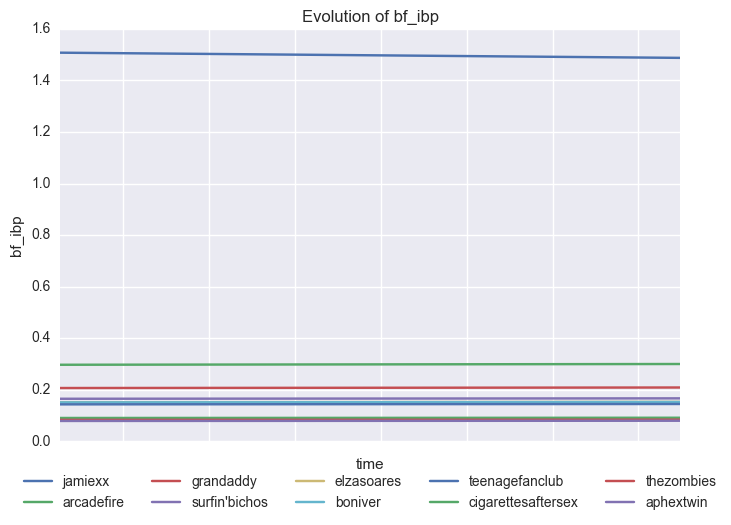

In [41]:
# Read current ranking
current_ranking = pd.read_sql_query("""	SELECT b.codedName AS bandCodedName, cr.tweets, cr.favs, cr.retweets, cr.bf_ibp 
                                       	FROM BandsHype AS cr 
                                    	LEFT JOIN Bands AS b ON cr.bandId = b.id""", connection)

# Read history of rankings
rankings = pd.read_sql_query("""SELECT b.codedName AS bandCodedName, rs.tweets, rs.favs, rs.retweets, rs.bf_ibp, rs.createdAt 
                            	FROM BandsHypeHis AS rs
                            	LEFT JOIN Bands AS b ON rs.bandId = b.id""", connection)

# filter last N-hours
rankings['createdAt'] = pd.to_datetime(rankings['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
recent_rankings = rankings[ rankings['createdAt'] > (datetime.now() - timedelta(hours=24))]

# get top-10 bands
top_10 = current_ranking.sort_values('bf_ibp', ascending = False)['bandCodedName'][0:10]

# plot band evolution
bands = top_10
ax4 = plt.figure().add_subplot(111)
for b in bands:
	recent_rankings[recent_rankings['bandCodedName'] == b].set_index('createdAt').plot(y='bf_ibp', label=b, ax=ax4)
ax4.set_title('Evolution of bf_ibp')
ax4.set_ylabel('bf_ibp')
ax4.set_xlabel('time')
ax4.set_xticklabels([])
plt.gcf().subplots_adjust(bottom=0.15)
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)

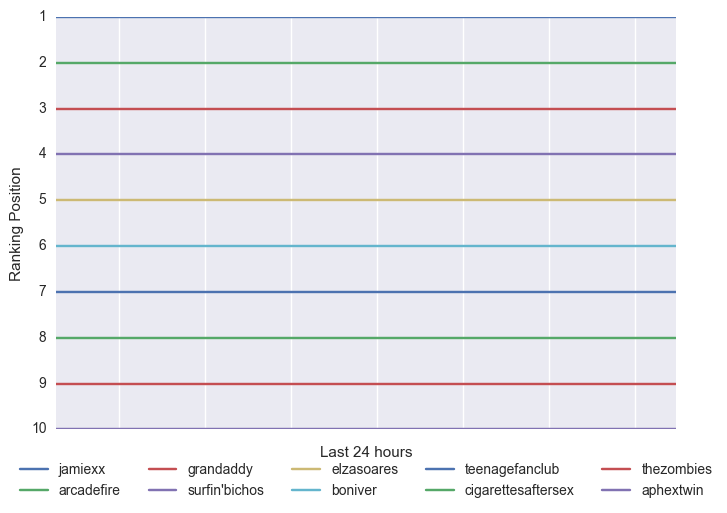

In [46]:
# Ranking plot by position

# Read current ranking
current_ranking = pd.read_sql_query("""	SELECT b.codedName AS bandCodedName, cr.tweets, cr.favs, cr.retweets, cr.bf_ibp, cr.ranking_position
                                       	FROM BandsHype AS cr 
                                    	LEFT JOIN Bands AS b ON cr.bandId = b.id""", connection)

# Read history of rankings
rankings = pd.read_sql_query("""SELECT b.codedName AS bandCodedName, rs.tweets, rs.favs, rs.retweets, rs.bf_ibp, rs.createdAt, rs.ranking_position  
                            	FROM BandsHypeHis AS rs
                            	LEFT JOIN Bands AS b ON rs.bandId = b.id""", connection)

# filter last N-hours
rankings['createdAt'] = pd.to_datetime(rankings['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
recent_rankings = rankings[ rankings['createdAt'] > (datetime.now() - timedelta(hours=24))]

# get top-10 bands
top_10 = current_ranking.sort_values('ranking_position', ascending = True)['bandCodedName'][0:10]

# plot band evolution
bands = top_10
ax4 = plt.figure().add_subplot(111)
for b in bands:
	recent_rankings[recent_rankings['bandCodedName'] == b].set_index('createdAt').plot(y='ranking_position', label=b, ax=ax4)
ax4.set_ylabel('Ranking Position')
ax4.set_xlabel('Last {} hours'.format(24))
ax4.set_xticklabels([])
plt.gcf().subplots_adjust(bottom=0.15)
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
ax4.invert_yaxis()